In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from PIL import Image
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [3]:
df = pd.read_csv("cleaned_dataset.csv")

In [4]:
df = df[df["Midline_Shift_Label"] != 2].reset_index(drop=True)
print("Filtered dataset shape:", df.shape)
print(df["Midline_Shift_Label"].value_counts())

Filtered dataset shape: (621, 6)
Midline_Shift_Label
0    316
1    305
Name: count, dtype: int64


In [5]:
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["Midline_Shift_Label"], random_state=42
)


In [6]:
class BrainShiftDirectionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["processed_image_path"]
        label = int(self.df.iloc[idx]["Midline_Shift_Label"])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [7]:
image_size = 224
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

In [8]:
train_dataset = BrainShiftDirectionDataset(train_df, transform=train_transform)
val_dataset = BrainShiftDirectionDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [9]:
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)


In [10]:
in_features = model.heads.head.in_features
model.heads.head = nn.Linear(in_features, 2)
model = model.to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [12]:
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    scheduler.step()
    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")

Epoch 1/15: 100%|██████████| 31/31 [00:22<00:00,  1.39it/s]


Epoch [1/15] Loss: 0.7440


Epoch 2/15: 100%|██████████| 31/31 [00:21<00:00,  1.43it/s]


Epoch [2/15] Loss: 0.6982


Epoch 3/15: 100%|██████████| 31/31 [00:21<00:00,  1.43it/s]


Epoch [3/15] Loss: 0.6963


Epoch 4/15: 100%|██████████| 31/31 [00:21<00:00,  1.44it/s]


Epoch [4/15] Loss: 0.6875


Epoch 5/15: 100%|██████████| 31/31 [00:21<00:00,  1.43it/s]


Epoch [5/15] Loss: 0.6949


Epoch 6/15: 100%|██████████| 31/31 [00:21<00:00,  1.43it/s]


Epoch [6/15] Loss: 0.6703


Epoch 7/15: 100%|██████████| 31/31 [00:21<00:00,  1.44it/s]


Epoch [7/15] Loss: 0.6325


Epoch 8/15: 100%|██████████| 31/31 [00:21<00:00,  1.44it/s]


Epoch [8/15] Loss: 0.6111


Epoch 9/15: 100%|██████████| 31/31 [00:21<00:00,  1.45it/s]


Epoch [9/15] Loss: 0.5401


Epoch 10/15: 100%|██████████| 31/31 [00:21<00:00,  1.44it/s]


Epoch [10/15] Loss: 0.4818


Epoch 11/15: 100%|██████████| 31/31 [00:20<00:00,  1.50it/s]


Epoch [11/15] Loss: 0.4675


Epoch 12/15: 100%|██████████| 31/31 [00:20<00:00,  1.49it/s]


Epoch [12/15] Loss: 0.4590


Epoch 13/15: 100%|██████████| 31/31 [00:21<00:00,  1.45it/s]


Epoch [13/15] Loss: 0.4348


Epoch 14/15: 100%|██████████| 31/31 [00:21<00:00,  1.46it/s]


Epoch [14/15] Loss: 0.4140


Epoch 15/15: 100%|██████████| 31/31 [00:21<00:00,  1.47it/s]

Epoch [15/15] Loss: 0.3857


In [13]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


=== Evaluation Results (ViT-B/16 — Midline Direction) ===
Accuracy : 0.5440
Precision: 0.5256
Recall   : 0.6721
F1 Score : 0.5899

Classification Report:

              precision    recall  f1-score   support

        Left       0.57      0.42      0.49        64
       Right       0.53      0.67      0.59        61

    accuracy                           0.54       125
   macro avg       0.55      0.55      0.54       125
weighted avg       0.55      0.54      0.54       125



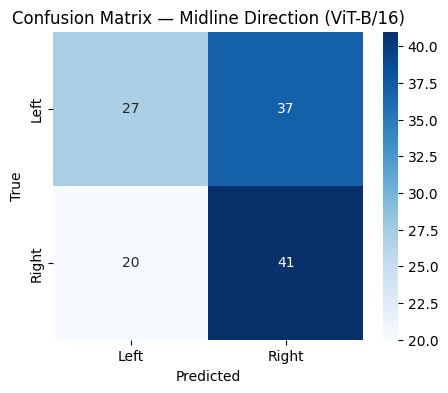

In [14]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n=== Evaluation Results (ViT-B/16 — Midline Direction) ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Left", "Right"]))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Left", "Right"], yticklabels=["Left", "Right"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Midline Direction (ViT-B/16)")
plt.show()

In [15]:
torch.save(model.state_dict(), "shift_direction_vit_b16.pth")
